
# Import libraries

In [1]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' 
from IPython.display import display, HTML
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

def ShowDataGraph(data_frame):

    colors = ["Red", "Green", "Blue", "Orange", "Gold", "Darkseagreen"]

    len_columns = len(data_frame.columns)

    columns_name = list(data_frame.columns)

    fig = make_subplots(rows=len_columns//2 + 1, cols=2, subplot_titles=tuple(columns_name))
    current_col = 1

    for i in columns_name:
        if data_frame[i].dtype == "object":
            fig.add_trace(go.Bar(x=list(dict(data_frame[i].value_counts(sort=False)).keys()) ,y=list(dict(data_frame[i].value_counts(sort=False)).values()) ), row=columns_name.index(i) //2 + 1 , col=current_col)
        
        else:
            fig.add_trace(go.Histogram(x=list(data_frame[i])), row=columns_name.index(i) //2 + 1 , col=current_col)
        current_col = current_col + 1 if current_col < 2 else 1
            
    fig.update_layout(height=200 * len_columns// 2 , width= 900 ,title="Feature values",template="plotly_white", showlegend=False)
    
    fig.show()

def showFeatureImportant(X_frame, y, target_names=["Class_1", "Class_2", "Class_3", "Class_4"]):
    # y must encoded

    # X_frame.columns
    fig = make_subplots(rows=len(X_frame.columns), cols=1, subplot_titles=X_frame.columns)

    for feature in X_frame.columns:
        x = X_frame[feature].unique()
        y_list = []
        unique_list = []
        
        for x_value in x:
            indexList = X_frame[feature].index[X_frame[feature] == x_value]
            Target = y.loc[indexList.tolist()]
            values, counts = np.unique(Target, return_counts=True)

            if len(values) == len(target_names):
                unique_list.append(values)
                y_list.append(counts)
            
            else:
                counts_temp = np.zeros((len(target_names),), dtype='int64')
                counts_temp[values] = counts
                unique_list.append(np.array([i for i in range(len(target_names))], dtype='int64'))
                y_list.append(counts_temp)

        y_show = [[y_list[i][value] for i in range(len(y_list))] for value in range(len(target_names))]

        for i in range(len(target_names)):
            fig.add_trace(go.Bar(x=x , y=y_show[i], name=target_names[i], legendgroup='group', showlegend=False if X_frame.columns.tolist().index(feature) != 0 else True), col=1, row=X_frame.columns.tolist().index(feature) + 1)

    fig.update_layout(barmode='stack')
    fig.show()

def showFeatureDistribute(X_frame, showing_features, y, plot_mode=2):
    
    y_show = y.copy()

    if y_show.name in X_frame.columns:
        data_show = X_frame.copy()

    else:
        data_show = pd.concat([X_frame, y_show], axis=1)

    # data_show[y.name] = ["Yes" if value==1 else "No" for value in data_show[y.name]]

    if plot_mode == 2: 
        assert len(showing_features) == 2
        fig = px.scatter(data_show, x=showing_features[0], y=showing_features[1], color=str(y.name))

        fig.update_traces(marker=dict(size=12,
                                line=dict(width=2,
                                            color='DarkSlateGrey')),
                    selector=dict(mode='markers'))
        fig.update_layout(hovermode="x", legend_traceorder='normal')

    else:
        assert len(showing_features) == 3
        fig = px.scatter_3d(data_show, x=showing_features[0], y=showing_features[1], z=showing_features[2], color=y.name, symbol=y.name)

    fig.show()

def unique_percent(X_frame, feature, y):

    x = sorted(X_frame[feature].unique().tolist())
    y_list = []
    unique_list = []
    
    matrix = np.zeros( (len(y.unique().tolist()), len(x)) )
    print(matrix.shape)
    for x_value in x:
        indexList = X_frame.index[X_frame[feature] == x_value]
        Target = y.loc[indexList.tolist()]
        values, counts = np.unique(Target, return_counts=True)

        for i in range(len(values)):
            matrix[values[i] , x.index(x_value)] = counts[i]
        
    table_temp = pd.DataFrame(matrix, columns=x)
    return table_temp

In [2]:
source_folder = r"D:\Coding_practice\_Data\tabular-playground-series-jun-2021"

train_path = os.path.join(source_folder, "train.csv")
train_csv = pd.read_csv(train_path, index_col='id')

test_path = os.path.join(source_folder, "test.csv")
test_csv = pd.read_csv(test_path , index_col='id')

In [3]:
def basic_info(train_csv, test_csv):
    print(f"Samples in train csv :\t{len(train_csv)}")
    print(f"Number of classes :\t{len(train_csv['target'].unique())}")
    print(f"Classes :\t{np.unique(train_csv['target'], return_inverse=False)}")
    print(f"Number of features :\t{len(set(train_csv.columns.tolist()) - set(['id','target']))}")
    print(f"Samples in test csv :\t{len(test_csv)}")

basic_info(train_csv, test_csv)
train_csv.describe(include='all')

Samples in train csv :	200000
Number of classes :	9
Classes :	['Class_1' 'Class_2' 'Class_3' 'Class_4' 'Class_5' 'Class_6' 'Class_7'
 'Class_8' 'Class_9']
Number of features :	75
Samples in test csv :	100000


feature_0      feature_1      feature_2      feature_3  \
count   200000.000000  200000.000000  200000.000000  200000.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean         0.972710       1.168365       2.219325       2.296735   
std          3.941836       3.993407       6.476570       7.551858   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%          1.000000       1.000000       1.000000       1.000000   
max         61.000000      51.000000      64.000000      70.000000   

            feature_4      feature_5      feature_6      feature_7  \
count   200000.000000  200000.000000  200000.000000  200000.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean         0.793530       1.431105       1.010695       0.673090   
std          2.935785       5.162746       3.949231       2.234949   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%          0.000000       1.000000       0.000000       0.000000   
max         38.000000      76.000000      43.000000      30.000000   

           feature_8      feature_9  ...     feature_66     feature_67  \
count   200000.00000  200000.000000  ...  200000.000000  200000.000000   
unique           NaN            NaN  ...            NaN            NaN   
top              NaN            NaN  ...            NaN            NaN   
freq             NaN            NaN  ...            NaN            NaN   
mean         1.94398       1.719655  ...       0.508695       1.827300   
std          3.93133       5.916988  ...       1.867330       7.188924   
min          0.00000       0.000000  ...       0.000000       0.000000   
25%          0.00000       0.000000  ...       0.000000       0.000000   
50%          0.00000       0.000000  ...       0.000000       0.000000   
75%          2.00000       1.000000  ...       0.000000       1.000000   
max         38.00000      72.000000  ...      24.000000      79.000000   

           feature_68     feature_69     feature_70     feature_71  \
count   200000.000000  200000.000000  200000.000000  200000.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean         0.910370       1.603585       1.219210       0.806895   
std          3.835182       4.877679       4.826003       2.458741   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000000       0.000000       0.000000       0.000000   
50%          0.000000       0.000000       0.000000       0.000000   
75%          1.000000       2.000000       1.000000       1.000000   
max         55.000000      65.000000      67.000000      30.000000   

           feature_72    feature_73     feature_74   target  
count   200000.000000  200000.00000  200000.000000   200000  
unique            NaN           NaN            NaN        9  
top               NaN           NaN            NaN  Class_6  
freq              NaN           NaN            NaN    51811  
mean         1.282925       2.94021       0.632005      NaN  
std          4.261420      10.78465       3.925310      NaN  
min          0.000000       0.00000       0.000000      NaN  
25%          0.000000       0.00000       0.000000      NaN  
50%          0.000000       0.00000       

# Visualize data

In [40]:
# print(train_pp.columns)
table_temp = unique_percent(refine_data, "feature_10_binned", refine_data['target'])

display(HTML(table_temp.to_html()))

(9, 3)


In [33]:
showFeatureImportant(refine_data[['feature_1_binned','feature_1_binned']], refine_data['target'], sorted(train_csv.target.unique().tolist()))
# showFeatureImportant(refine_data[sorted(list(set(refine_data.columns) - set(['target'])))], refine_data['target'], sorted(train_csv.target.unique().tolist()))

KeyError: 'target'

In [ ]:
from sklearn.manifold import TSNE
t_sne = TSNE(n_components=2)
train_show = train_pp.copy()

train_show = t_sne.fit_transform(train_show.drop(columns=["target","id","fold"]).to_numpy(), train_show.target.to_numpy())

train_show = np.hstack((train_show, train_pp.target.to_numpy().reshape(-1,1)))

data_ = pd.DataFrame(data= train_show,columns=["feature_1","feature_2","target"])

In [ ]:
showFeatureDistribute(X_frame=refine_data[:1000], showing_features=["std_row", 'non_zero_qual',"total_values"], y=refine_data['target'][:1000], plot_mode=3)

In [ ]:
from sklearn.cluster import KMeans
kmean = KMeans(n_clusters=len(np.unique(train_pp['target'], return_inverse=False)), max_iter=1000, verbose=1)

# Preprocess

In [4]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(np.unique(train_csv['target'], return_inverse=False))
target = 'target'

train_pp = train_csv.copy()
test_pp = test_csv.copy()

train_pp[target] = le.transform(train_pp[target])

display(HTML(train_pp.describe(include='all').to_html()))


In [6]:
def Statistic(df, target='target'):
    statistic_features = [i for i in df.columns.tolist() if i not in ['id','target']]

    for feature in statistic_features:
        print(pd.concat([df.groupby([feature])[target].value_counts(normalize=True),df.groupby([feature])[target].value_counts()], axis=1))
        print("-"*20)

    return df_st


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
def Correlation_feature(df):
    correlations = df.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show()

In [8]:
def quantity_count_features(row, group=0, step=10, non_zero=1):

    x = np.array([row[f'feature_{i}'] > 0 if non_zero else row[f'feature_{i}'] == 0 for i in range(group * step,  group * step + step)]).sum()

    return x

def value_count_features(row, group=0, step=10):

    x = np.array([row[f'feature_{i}'] for i in range(group * step,  group * step + step)]).sum()

    return x

def object_count_feature(row, object_name):

    x = len(np.where(row == object_name)[0])

    return x

def mean_value(row, n_feature):

    x = np.array([row[f"feature_{i}"] for i in range(n_feature)]).mean()

    # if row[f"feature_{i}"] > 0

    return x

def std_value(row, n_feature):

    x = np.array([row[f"feature_{i}"] for i in range(n_feature)]).std()

    return x

def z_score_row(row):

    x = np.array((row["total_values"] - row["mean"]) / row['std'])

    return x

def zeros_n_values_percent(row):

    x =np.array( row["zeros_count_total"] / row["total_values"])

    return x 

## Get mean and standard deviation of everypoint per columns
def get_mean_n_std(data_frame):
    col_names = [cname for cname in data_frame.columns]
    
    mean_n_std = []
    # for cname in col_names:
    mean, std = data_frame.mean(), data_frame.std()
    mean_n_std.append(mean)
    mean_n_std.append(std)

    mean_n_std = np.array(mean_n_std)
    mean_n_std_df = pd.DataFrame(data= mean_n_std, index=['mean','std'], columns=col_names)

    return mean_n_std_df

## Standarize data point every columns in dataframe
def get_normalize(data_frame, mean_n_std_frame, nor_type="z"):
    """
    There are 3 type of normalize:
    "s" : simple feature scaling : x_new = x_old / x_max
    "m" : Min - Max : x_new = (x_old - x_min) / (x_max - x_min)
    "z" : Z-score : x_new = (x_old - mean) / std
    """
    assert len(data_frame.columns) == len(mean_n_std_frame.columns)

    col_names = [cname for cname in data_frame.columns]

    standarize_df = data_frame.copy()

    if nor_type=="s":
        standarize_df = standarize_df / standarize_df.max()

    elif nor_type == "m":
        standarize_df = (standarize_df - standarize_df.min())/ standarize_df.max() - standarize_df.min()

    elif nor_type == "z":
        standarize_df = (standarize_df - mean_n_std_frame.loc['mean']) / mean_n_std_frame.loc['std']

    else:
        pass

    return standarize_df

def binning_features(data_frame, features, group_names=['Low','Medium','High'], n_bins=3):
    binned_df = data_frame.copy()

    for feature in features:
        bins = np.linspace(min(binned_df[feature]), max(binned_df[feature]), n_bins + 1)

        binned_df[feature+"_binned"] = pd.cut(binned_df[feature],
                                                bins,
                                                labels = group_names,
                                                include_lowest=True
                                                )

    return binned_df

def positive_encoding(df):

    encoded_values = df.values > 0
    encoded_df = pd.DataFrame(encoded_values.astype('int32'), columns=df.columns, index=df.index)

    return encoded_df

def apply_feature_engineering(train_dtframe, test_dtframe):
    train_data = train_dtframe.copy()
    test_data = test_dtframe.copy()
    features = [i for i in train_data.columns.tolist() if i not in ['id','target']]
    no_feature = len(features)

    """
    Apply Positive encoding
    """

    # train_data[features] = positive_encoding(train_data[features])
    # test_data[features] = positive_encoding(test_data[features])
    """
    Count the features match with condition
    """
    # train_data["non_zero_qual"] = train_data.apply(quantity_count_features, group=0, step=no_feature, non_zero=0, axis=1)
    # test_data["non_zero_qual"] = test_data.apply(quantity_count_features, group=0, step=no_feature, non_zero=0, axis=1)

    for feature in features:
        """
        Cap outlier data
        """
        upper_lim = train_data[feature].quantile(.95)
        train_data.loc[(train_data[feature] > upper_lim), feature] = upper_lim
        test_data.loc[(test_data[feature] > upper_lim), feature] = upper_lim

    """
    Get mean value of each features
    """
        # train_feature_mean = train_data[feature].mean()
        # test_feature_mean = test_data[feature].mean()

    """
    Replace 0 with the mean value of each features
    """
        # train_data[feature].replace(0, train_feature_mean, inplace=True)
        # test_data[feature].replace(0, test_feature_mean, inplace=True)

    """
    Apply log
    """
        # train_data[feature] =  np.log(train_data[feature] - train_data[feature].min() + 1)
        # test_data[feature] = np.log(test_data[feature] - test_data[feature].min() + 1)

        # train_data[feature].iloc[np.where(train_data[feature] != feature_mean)] = 0

    """
    # Binning feature
    """
    # binning_names = ['Low','Medium','High']
    # train_data = binning_features(train_data, features, group_names=binning_names, n_bins=len(binning_names))
    # test_data = binning_features(test_data, features, group_names=binning_names, n_bins=len(binning_names))
    """
    # Count number of bin name
    """
    # for bin_name in binning_names:
    #     train_data["n_"+bin_name] = train_data.apply(object_count_feature, object_name=bin_name, axis=1)
    #     test_data["n_"+bin_name] = test_data.apply(object_count_feature, object_name=bin_name, axis=1)

    """
    Sum value of the features
    """
    # train_data["total_values"] = train_data.apply(value_count_features, group=0, step=no_feature, axis=1)
    # test_data["total_values"] = test_data.apply(value_count_features, group=0, step=no_feature, axis=1) 

    """
    Mean value of a sample
    """
    # train_data['mean_row'] = train_data.apply(mean_value, n_feature=no_feature, axis=1)
    # test_data['mean_row'] = test_data.apply(mean_value, n_feature=no_feature, axis=1)

    """
    Std value of a sample
    """
    # train_data['std_row'] = train_data.apply(std_value, n_feature=no_feature, axis=1)
    # test_data['std_row'] = test_data.apply(std_value, n_feature=no_feature, axis=1)

    """
    Remove certain columns
    """
    # train_data.drop(columns=[f"feature_{i}" for i in range(no_feature)], inplace=True)
    # test_data.drop(columns=[f"feature_{i}" for i in range(no_feature)], inplace=True)

    # train_data.drop(columns=[f"feature_{i}_binned" for i in range(no_feature)], inplace=True)
    # test_data.drop(columns=[f"feature_{i}_binned" for i in range(no_feature)], inplace=True)

    """
    # Standardized data
    """
    # preprocess_feature = [i for i in train_data.columns.tolist() if i not in ['id','target']]

    # mean_n_std_df = get_mean_n_std(train_data[preprocess_feature])
    # train_data[preprocess_feature] = get_normalize(train_data[preprocess_feature], mean_n_std_df, nor_type='m')
    # test_data[preprocess_feature] = get_normalize(test_data[preprocess_feature], mean_n_std_df, nor_type='m')

    return train_data, test_data

In [9]:
refine_data, refined_test_data = apply_feature_engineering(train_pp, test_pp)

display(HTML(refine_data.describe(include='all').to_html()))

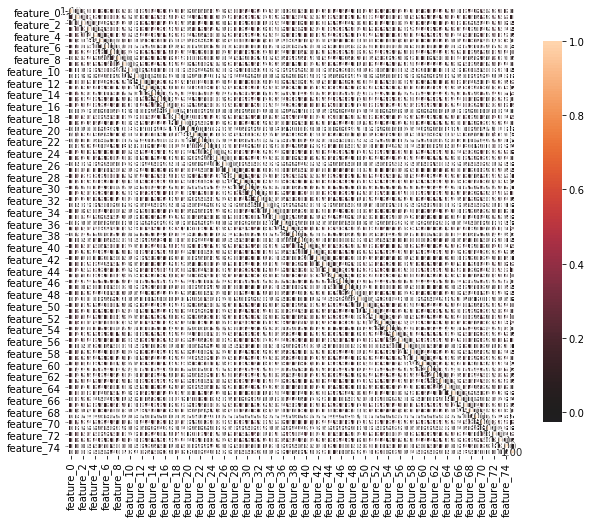

In [14]:
Correlation_feature(df=refine_data)

In [10]:
df_st = Statistic(df=refine_data , target='target')

  0       0.046421    5974
           3       0.024244    3120
           4       0.014873    1914
1.0        7       0.309971   12087
           5       0.263297   10267
           8       0.123634    4821
           6       0.084244    3285
           1       0.080474    3138
           2       0.058599    2285
           0       0.042468    1656
           3       0.022055     860
           4       0.015259     595
2.0        7       0.316600    5266
           5       0.264775    4404
           8       0.117958    1962
           6       0.085132    1416
           1       0.075332    1253
           2       0.056334     937
           0       0.044971     748
           3       0.022305     371
           4       0.016594     276
3.0        7       0.316860    4969
           5       0.241423    3786
           8       0.125558    1969
           6       0.094631    1484
           1       0.076840    1205
           2       0.057199     897
           0       0.047188     740
 

NameError: name 'df_st' is not defined

In [ ]:
print(display(HTML(refine_data.iloc[np.where(refine_data.target ==0)].sample(20).to_html())))

In [124]:
refine_data.sample(5)

target  non_zero_qual  n_Lower  n_Low  n_Medium  n_High  n_Higher  \
id                                                                          
73982        1             63       66      3         2       2         2   
42158        8             71       73      1         0       0         1   
74462        7             39       50     12         0       6         7   
135862       6             21       32      8         5       4        26   
48143        5             47       57      8         1       3         6   

        total_values  
id                    
73982           24.0  
42158            6.0  
74462           99.0  
135862         234.0  
48143           92.0

In [39]:
showFeatureImportant(refine_data[['feature_0_binned','feature_1_binned']], refine_data['target'], sorted(train_csv.target.unique().tolist()))

In [127]:
print(display(HTML(refine_data.iloc[np.where(refine_data.target ==0)].describe(include='all').to_html())))

print(display(HTML(refine_data.iloc[np.where(refine_data.target ==1)].describe(include='all').to_html())))

None


None


# Split data into 5 folds

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 0
refine_data['fold'] = 0
for _, test_index in skf.split(refine_data.index, refine_data['target']):
    
    refine_data['fold'].iloc[test_index] = fold
    fold += 1

In [129]:
refine_data.head(5)
np.unique(refine_data['fold'], return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([40000, 40000, 40000, 40000, 40000], dtype=int64))

# Build model

In [11]:
train = refine_data[refine_data['fold']!=0].reset_index(drop=True)
valid = refine_data[refine_data['fold']==0].reset_index(drop=True)

In [19]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.manifold import TSNE
import torch
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgbm
import sklearn.metrics as sk_metric
import sklearn.model_selection as sk_ms

def simple_training_ss(train_data, validate=True, target_column='target'):

    X_data = train_data.copy()
    X_data.drop(columns=['fold'], inplace=True)
    y_data = X_data.pop(target_column)

    model = LogisticRegression(solver='lbfgs', max_iter=1000)

    if validate:
        print("Cross validate model.....")
        lr_cv_score = sk_ms.cross_val_score(
                                            model,
                                            X_data, y_data,
                                            cv=5,
                                            scoring=sk_metric.make_scorer(sk_metric.log_loss, greater_is_better=False, needs_proba=True)) * -1
        
        lr_loss = np.mean(lr_cv_score)
        print(f"Mean: {lr_loss}, Folds: {lr_cv_score}")

    else:
        print("Fitting model.......")
        model.fit(X_data, y_data)
    
    print("-"*5 +" Finish " + "-"*5)

    return model

def training_ss(train_data, valid_data, model="tabnet", target_column='target'):
    print("Splitting data....")
    X_train = train_data.copy()
    X_valid = valid_data.copy()

    X_train.drop(columns=['fold'], inplace=True)
    X_valid.drop(columns=['fold'], inplace=True)

    y_train = X_train.pop(target_column)
    y_valid = X_valid.pop(target_column)

    X_train = X_train.to_numpy()
    X_valid = X_valid.to_numpy()

    y_train = y_train.to_numpy()
    y_valid = y_valid.to_numpy()

    # t_sne = TSNE(n_components=2)
    # X_train = t_sne.fit_transform(X_train)
    # X_valid = t_sne.fit_transform(X_valid)
    
    print("Start training....")
    if model.lower()=="tabnet":

        clf = TabNetClassifier(
            n_d=64, n_a=64, n_steps=5,
            gamma=1.5, n_independent=2, n_shared=2,
            lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=5e-3),
            scheduler_params = {"gamma": 0.95,
                                "step_size": 20},
            scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
        )

        clf.fit(
            X_train=X_train, y_train=y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            eval_name=['train', 'valid'],
            max_epochs=1000, patience=10,
            batch_size=1024, virtual_batch_size=128
        )

    else:
        clf = XGBClassifier(max_depth=8,
        learning_rate=0.1,
        n_estimators=1000,
        verbosity=0,
        silent=None,
        objective="binary:logistic",
        booster='gbtree',
        n_jobs=-1,
        nthread=None,
        gamma=0,
        min_child_weight=1,
        max_delta_step=0,
        subsample=0.7,
        colsample_bytree=1,
        colsample_bylevel=1,
        colsample_bynode=1,
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        base_score=0.5,
        random_state=0,
        seed=None,)

        clf.fit(X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                early_stopping_rounds=200,
                verbose=10)
    return clf

In [21]:
# clf = training_ss(train, valid)
clf = simple_training_ss(refine_data, validate=False)

Fitting model
----- Finish -----


# Return result

In [133]:
np.unique(train_csv.target)

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

In [22]:
preds_test = clf.predict_proba(refined_test_data.to_numpy())

data = {}

data['id'] = refined_test_data.index

for i, class_target in enumerate(np.unique(train_csv.target)):
    data[class_target] = preds_test[:,i]

output = pd.DataFrame(data)

output.to_csv('pos_encoding.csv', index=False)